# Seq2Seq

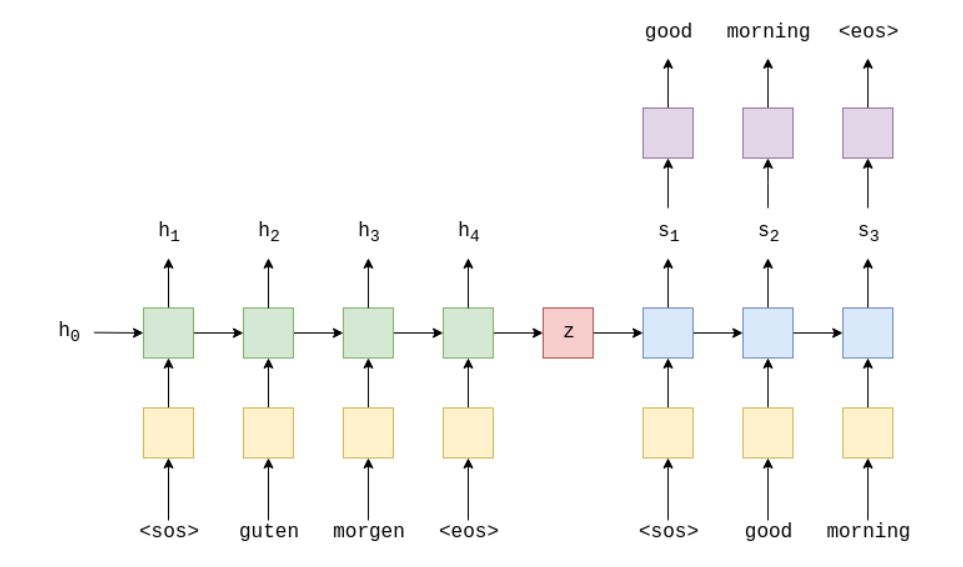

$\begin{aligned} & h_t=\operatorname{sigm}\left(W^{h x} x_t+W^{h h} h_{t-1}\right) \\ & y_t=W^{y h} h_t\end{aligned}$

$p\left(y_1, \ldots, y_{T^{\prime}} \mid x_1, \ldots, x_T\right)=\prod_{t=1}^{T^{\prime}} p\left(y_t \mid v, y_1, \ldots, y_{t-1}\right)$

## Prepare the Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm
import evaluate


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\DELL\Desktop\paper implementation\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\DELL\Desktop\paper implementation\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\DELL\Desktop\paper implementation\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))  # Should print your GPU name if available

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:


seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True



### Dataset

In [6]:
dataset = datasets.load_dataset("bentrevett/multi30k")

In [12]:
de_nlp = spacy.load("de_core_news_sm")
en_nlp = spacy.load("en_core_web_sm")

In [9]:


train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)



In [11]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

In [13]:


string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]



['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [14]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [15]:


max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)



Map: 100%|██████████| 1000/1000 [00:00<00:00, 6577.10 examples/s]


In [16]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

In [17]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [18]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [19]:
len(en_vocab), len(de_vocab)

(5893, 7853)

In [20]:


assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]



In [21]:


en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)



In [22]:
tokens = ["i", "love", "watching", "crime", "shows"]
en_vocab.lookup_indices(tokens)

[956, 2169, 173, 0, 821]

In [23]:


def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}



In [24]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 4995.67 examples/s]


In [25]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>'],
 'en_ids': [2, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 3],
 'de_ids': [2, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 3]}

In [26]:


data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)



In [27]:
train_data[0]

{'en_ids': tensor([   2,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
            3]),
 'de_ids': tensor([   2,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
         3171,    4,    3]),
 'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

In [28]:


def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn




In [29]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [30]:


batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)



## Building the model

### Encoder

$\begin{aligned} & \left(h_t^1, c_t^1\right)=\operatorname{EncoderLSTM}^1\left(e\left(x_t\right),\left(h_{t-1}^1, c_{t-1}^1\right)\right) \\ & \left(h_t^2, c_t^2\right)=\operatorname{EncoderLSTM}^2\left(h_t^1,\left(h_{t-1}^2, c_{t-1}^2\right)\right)\end{aligned}$

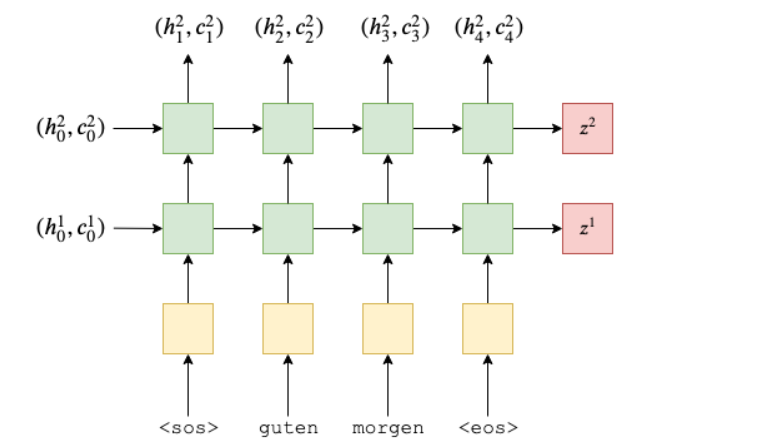

In [31]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

### Decoder

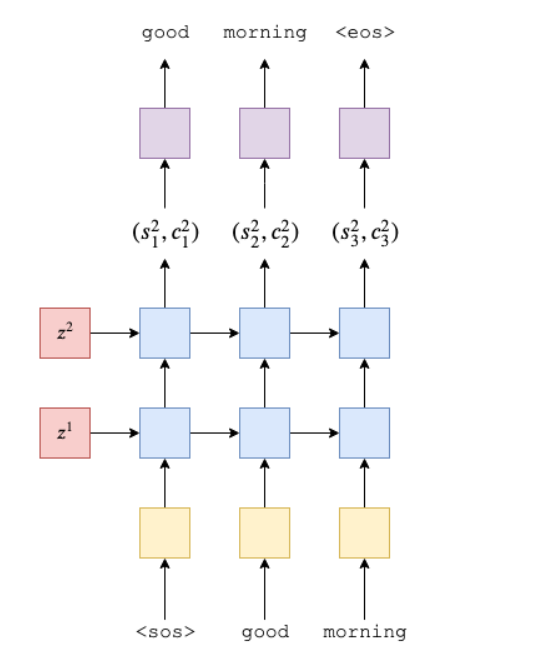

$\begin{array}{r}\left(s_t^1, c_t^1\right)=\operatorname{DecoderLSTM}^1\left(d\left(y_t\right),\left(s_{t-1}^1, c_{t-1}^1\right)\right) \\ \left(s_t^2, c_t^2\right)=\operatorname{DecoderLSTM}^2\left(s_t^1,\left(s_{t-1}^2, c_{t-1}^2\right)\right)\end{array}$

In [32]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

### Seq to Seq

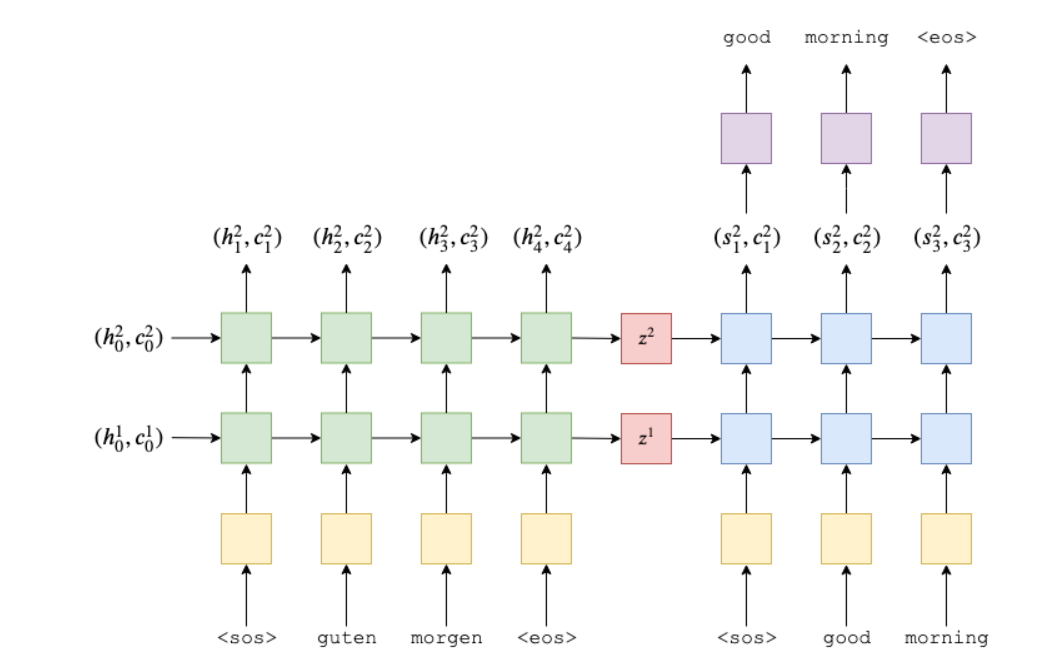

In [33]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

## Training model

In [34]:


input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)



In [35]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [36]:


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")



The model has 13,898,501 trainable parameters


In [37]:
optimizer = optim.Adam(model.parameters())

In [38]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [39]:


def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)



In [40]:


def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)



In [41]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

 10%|█         | 1/10 [00:44<06:39, 44.43s/it]

	Train Loss:   5.035 | Train PPL: 153.687
	Valid Loss:   4.956 | Valid PPL: 142.011


 20%|██        | 2/10 [01:28<05:52, 44.11s/it]

	Train Loss:   4.406 | Train PPL:  81.939
	Valid Loss:   4.664 | Valid PPL: 106.068


 30%|███       | 3/10 [02:17<05:26, 46.58s/it]

	Train Loss:   4.110 | Train PPL:  60.921
	Valid Loss:   4.569 | Valid PPL:  96.412


 40%|████      | 4/10 [03:15<05:06, 51.02s/it]

	Train Loss:   3.911 | Train PPL:  49.924
	Valid Loss:   4.311 | Valid PPL:  74.530


 50%|█████     | 5/10 [04:05<04:13, 50.75s/it]

	Train Loss:   3.708 | Train PPL:  40.762
	Valid Loss:   4.213 | Valid PPL:  67.586


 60%|██████    | 6/10 [04:48<03:11, 47.96s/it]

	Train Loss:   3.533 | Train PPL:  34.220
	Valid Loss:   4.040 | Valid PPL:  56.806


 70%|███████   | 7/10 [05:31<02:18, 46.20s/it]

	Train Loss:   3.381 | Train PPL:  29.415
	Valid Loss:   3.993 | Valid PPL:  54.222


 80%|████████  | 8/10 [06:26<01:38, 49.26s/it]

	Train Loss:   3.240 | Train PPL:  25.539
	Valid Loss:   3.966 | Valid PPL:  52.799


 90%|█████████ | 9/10 [07:26<00:52, 52.57s/it]

	Train Loss:   3.101 | Train PPL:  22.220
	Valid Loss:   3.902 | Valid PPL:  49.507


100%|██████████| 10/10 [08:10<00:00, 49.02s/it]

	Train Loss:   2.983 | Train PPL:  19.738
	Valid Loss:   3.790 | Valid PPL:  44.247


In [42]:


model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")



| Test Loss: 3.782 | Test PPL:  43.924 |


In [43]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = de_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden, cell = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens

In [44]:


sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation



('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

In [45]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [46]:
translation

['<sos>',
 'a',
 'man',
 'in',
 'a',
 'blue',
 'jacket',
 'is',
 'holding',
 'his',
 '.',
 '<eos>']

In [47]:
## loop over test data


translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_data)
]



100%|██████████| 1000/1000 [00:10<00:00, 94.40it/s]


In [48]:
bleu = evaluate.load("bleu")

In [49]:


predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]



In [59]:
example = test_data[0]
example

{'en_ids': tensor([   2,    4,    9,    6,   21,   86,   67, 2599,   20,  121,    5,    3]),
 'de_ids': tensor([  2,   5,  13,  11,   6, 175, 106,   9,  15,  75,   0,   4,   3]),
 'en': 'A man in an orange hat starring at something.',
 'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'en_tokens': ['<sos>',
  'a',
  'man',
  'in',
  'an',
  'orange',
  'hat',
  'starring',
  'at',
  'something',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'ein',
  'mann',
  'mit',
  'einem',
  'orangefarbenen',
  'hut',
  ',',
  'der',
  'etwas',
  'anstarrt',
  '.',
  '<eos>']}

In [50]:
predictions[0], references[0]

('a man in a blue jacket is holding his .',
 ['A man in an orange hat starring at something.'])

In [63]:
sentence = "der Mann ist mit seiner Freundin zusammen."
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)
print(translation)

['<sos>', 'the', 'man', 'is', 'the', 'his', '.', '.', '<eos>']


In [52]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [54]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])

(['a', 'man', 'in', 'a', 'blue', 'jacket', 'is', 'holding', 'his', '.'],
 ['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.'])

In [55]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)
results

{'bleu': 0.14175580143977276,
 'precisions': [0.4885898646521876,
  0.19875298940895114,
  0.096096376540904,
  0.04831067161104244],
 'brevity_penalty': 0.9728341086764001,
 'length_ratio': 0.9731965078878848,
 'translation_length': 12708,
 'reference_length': 13058}